# Setup


In [234]:
import pandas as pd
import numpy as np
from glob import glob
from re import match, sub
from missingno import matrix as mmatrix
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from math import ceil
from datetime import datetime, timedelta
import scipy
from scipy.stats import pearsonr, norm
from statsmodels.formula.api import ols
from os import listdir
from collections import defaultdict
from functools import partial
from json import dumps, loads

palette = partial(sns.color_palette, "colorblind")


In [195]:
if 'figure_dir.txt' in listdir():
    with open('figure_dir.txt', 'r') as f:
        fig_dir = f.readline().strip().replace('\\', '/')
        tbl_dir = f"{fig_dir.rsplit('/', maxsplit=2)[0]}/Tables/"
else:
    fig_dir = 'Figures/'
    tbl_dir = 'Tables/'

def trim_trailing_zeros(number_string):
    '''
    Take a string with numbers and remove any trailing zeros from the number.
    '''
    return sub(
        r'(?:\.0+|(\.\d+)0+)(%?)$', 
        '\\1\\2', number_string
    )

def neaten_ticks(
        ax, axis, tick_range, ticks, dp=0, fmt='f', twin=False):
    '''
    Take a plot ax and convert its x or y axis into a neatened range frame.
    '''
    # Set sets.
    eval(f"ax.set_{axis}ticks")(sorted([*ticks, *tick_range]))
    is_log = eval(f"ax.get_{axis}scale")() == 'log' 
    # Set labels.
    eval(f"ax.set_{axis}ticklabels")([
        f"$\\mathdefault{{10^{{{ex:.0f}}}}}$" 
        if is_log and int((ex := np.log10(e))) == ex 
        else trim_trailing_zeros(eval(f'''f"{{e:.0{dp}{fmt}}}"'''))
        for e in eval(f"ax.get_{axis}ticks")()
    ])
    # Limit axis outline to data range.
    ax.spines[
        'right' if twin else 'bottom' if axis == 'x' else 'left'
    ].set_bounds(*tick_range)

def show(
    fig, axes=[], tight=False, despine=True, despine_twin=False, 
    delax=True, file=None, legend_loc=0, style_legend=True, filetype='pdf'
):
    '''Style and show a matplotlib plot.'''
    if tight: plt.tight_layout() # Neaten subplots.
    # Remove unnecessary outlines from plots with twin axes.
    # Note that this method assumes all axes have twins.
    if despine_twin:
        for ax in axes[::2]:
            ax.spines['top'].set_visible(False)
            # ax.spines['bottom'].set_visible(False)
            ax.spines['right'].set_visible(False)
        for ax in axes[1::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
    # Remove unnecessary outlines.
    elif despine:
        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    for ax in axes:
    # Remove unused subplots.
        if delax and not ax.has_data(): fig.delaxes(ax)
        ax.tick_params(
            axis='both', which='minor', 
            bottom=False, left=False, right=False
        )
        # Style the legend if permitted and a legend is present.
        if ax.get_legend() and style_legend:
            handles, labels = ax.get_legend_handles_labels()
            labels = [e.title() for e in labels]
            legend_title = ax.get_legend().get_title().get_text().title()
            ax.legend(
                handles=handles, labels=labels, 
                title=legend_title, loc=legend_loc
            )
    # Save file if a filename is provided.
    if file:
        plt.savefig(
            f'{fig_dir}/Plots/{file}.{filetype}', dpi = 300,
            bbox_inches = 'tight', pad_inches = 1/25
        )
    plt.show()

def to_model_label(name):
    label = 'Multivariate ' if 'multiv' in name else 'Univariate '
    label += 'Deep ' if 'deep' in name else 'Shallow '
    label += 'MLP' if 'MLP' in name else 'BD-LSTM'
    return label


# Learning rate experiment summary

In [11]:
lr_smry_df = pd.read_csv('Results/lr scheduler comparison on shallow MLP.csv')

lr_smry_df = lr_smry_df.melt(id_vars='function', var_name='Step', value_name='MAPE')

lr_smry_df


,function,Step,MAPE
0,scheduler1,H1,1.234822
1,scheduler1,H1,1.084792
2,scheduler1,H1,1.160965
3,scheduler1,H1,1.068854
4,scheduler1,H1,1.082540
...,...,...,...
75,scheduler4,H24,3.811834
76,scheduler4,H24,3.856075
77,scheduler4,H24,4.101814
78,scheduler4,H24,3.876484


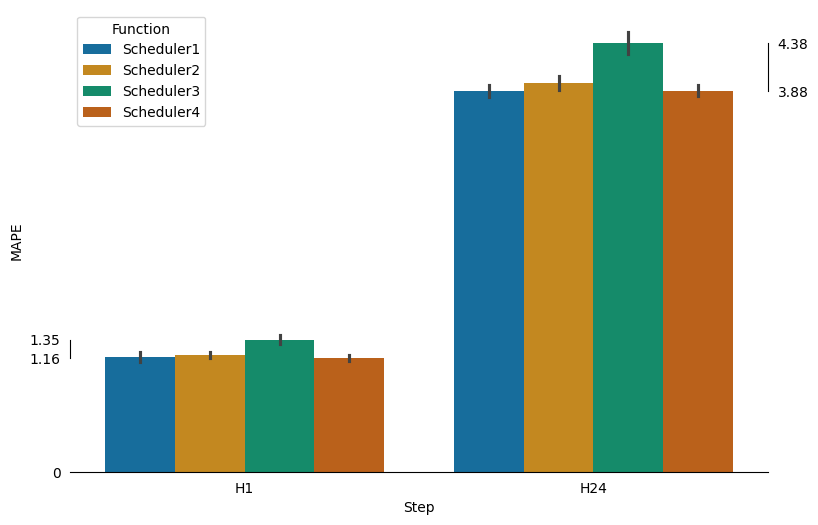

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(data=lr_smry_df, x='Step', y='MAPE', hue='function', palette=palette(lr_smry_df.function.nunique()))

h1_means = lr_smry_df[lr_smry_df.Step == 'H1'].groupby(['function']).MAPE.mean()
neaten_ticks(ax, 'y', [h1_means.min(), h1_means.max()], [0], dp=2)

ax2 = ax.twinx()
h24_means = lr_smry_df[lr_smry_df.Step == 'H24'].groupby(['function']).MAPE.mean()
neaten_ticks(ax2, 'y', [h24_means.min(), h24_means.max()], [], dp=2, twin=True)
ax2.set_ylim(*ax.get_ylim())

ax.tick_params(axis='both', color='white')
ax2.tick_params(axis='both', color='white')

show(fig, [ax, ax2], delax=False, despine_twin=True)


In [13]:
from scipy.stats import ttest_ind

for stp in lr_smry_df.Step.unique():
    x = lr_smry_df[(
        (lr_smry_df.function.isin(['scheduler4']))
        & (lr_smry_df.Step == stp)
    )].MAPE
    y = lr_smry_df[(
        (lr_smry_df.function.isin(['scheduler2']))
        & (lr_smry_df.Step == stp)
    )].MAPE
    print(ttest_ind(x, y, equal_var=False, alternative='less').pvalue)


0.09560384352074065
0.0627277513614938


In [14]:
def ci(data: pd.Series, alpha=0.05):
    return norm.ppf(.975) * data.std(ddof=0) / len(data)**.5
    

In [15]:
with open('Results/lr scheduler comparison on shallow MLP.json', 'r') as f:
    lr_res = pd.DataFrame(loads(f.read()))

lr_res_df = pd.DataFrame()

for col in lr_res:
    xx = lr_res[col].apply(pd.Series).loss.apply(pd.Series).agg(['mean', ci]).T
    yy = lr_res[col].apply(pd.Series).val_loss.apply(pd.Series).agg(['mean', ci]).T
    for i, zz in enumerate([xx, yy]):
        zz['upper'] = zz['mean'] + zz.ci
        zz['lower'] = zz['mean'] - zz.ci
        zz = zz.drop(columns=['ci'])
        zz['set'] = 'validation' if i else 'train'
        zz['function'] = col
        zz['epoch'] = zz.index + 1
        lr_res_df = pd.concat([lr_res_df, zz]).reset_index(drop=True)
    
lr_res_df


,mean,upper,lower,set,function,epoch
0,99.903358,99.919843,99.886872,train,scheduler1,1
1,99.568192,99.635720,99.500663,train,scheduler1,2
2,98.016785,98.286571,97.746999,train,scheduler1,3
3,94.006918,94.743375,93.270462,train,scheduler1,4
4,86.196698,87.666146,84.727250,train,scheduler1,5
...,...,...,...,...,...,...
15995,2.508362,2.545373,2.471352,validation,scheduler4,1996
15996,2.508346,2.545364,2.471328,validation,scheduler4,1997
15997,2.508301,2.545298,2.471304,validation,scheduler4,1998
15998,2.508275,2.545282,2.471268,validation,scheduler4,1999


In [112]:
# cols = lr_res_df.set.unique()
# n_col, n_row = len(cols), 2

# fig, axes = plt.subplots(n_row, n_col, figsize=(9*n_col, 6*n_row))
# axes = axes.flatten()
# fill = palette(lr_res_df.function.nunique())

# for i in range(n_col*n_row):
#     ax, col = axes[i], cols[i % 2]

#     data=lr_res_df[(
#         (lr_res_df.set == col)
#         & (lr_res_df.index % 2 == 1)
#      )]
#     if i >= 2:
#         yticks = []
#         data = data[data.epoch >= 1750]
#         title, xlabel, ylabel = '', 'Epoch', ''
#     else:
#         yticks = [50]
#         title, xlabel, ylabel = col.title(), '', ''
#     if i % 2 == 0:
#         ylabel = 'MAPE'

#     sns.lineplot(
#         ax=ax, data=data, x='epoch', y='mean', hue='function', 
#         palette=fill, alpha=0.8
#     )

#     ax.set_title(title)
#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)

#     for j, fnct in enumerate(data.function.unique()):
#         data_f = data[data.function == fnct]
#         ax.fill_between(
#             data_f.epoch, 
#             data_f.upper, 
#             data_f.lower, 
#             alpha=0.1,
#             color=fill[j]
#         )

#     data_s = data[data.set == col]
#     ax.set_yticks([])
#     neaten_ticks(ax, 'y', [data_s['mean'].min(), data_s['mean'].max()], yticks, dp=3)
#     neaten_ticks(ax, 'x', [data_s.epoch.min(), data_s.epoch.max()], [])

#     if i != 1:
#         ax.get_legend().remove()
        
#     ax.tick_params(axis='both', color='white')

# show(fig, axes)


# ~~Weight decay experiment summary~~

In [17]:
wd_smry_df = pd.read_csv('Results/weight decay comparison on shallow MLP.csv')

wd_smry_df = wd_smry_df.melt(id_vars='weight_decay', var_name='Step', value_name='MAPE')

wd_smry_df


,weight_decay,Step,MAPE
0,0.00000,H1,1.076746
1,0.00000,H1,1.245005
2,0.00000,H1,1.213953
3,0.00000,H1,1.251266
4,0.00000,H1,1.223955
...,...,...,...
75,0.00001,H24,4.104717
76,0.00001,H24,4.071819
77,0.00001,H24,4.041662
78,0.00001,H24,3.816740


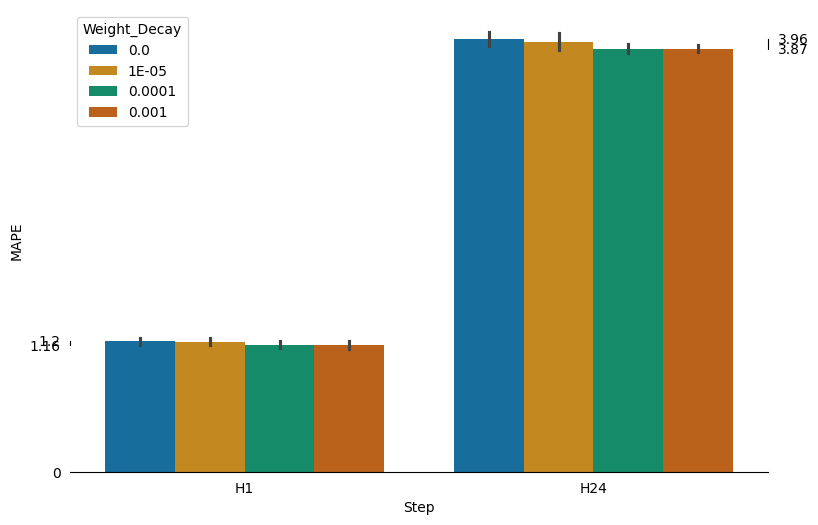

In [18]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(data=wd_smry_df, x='Step', y='MAPE', hue='weight_decay', palette=palette(wd_smry_df.weight_decay.nunique()))

h1_means = wd_smry_df[wd_smry_df.Step == 'H1'].groupby(['weight_decay']).MAPE.mean()
neaten_ticks(ax, 'y', [h1_means.min(), h1_means.max()], [0], dp=2)

ax2 = ax.twinx()
h24_means = wd_smry_df[wd_smry_df.Step == 'H24'].groupby(['weight_decay']).MAPE.mean()
neaten_ticks(ax2, 'y', [h24_means.min(), h24_means.max()], [], dp=2, twin=True)
ax2.set_ylim(*ax.get_ylim())

ax.tick_params(axis='both', color='white')
ax2.tick_params(axis='both', color='white')

show(fig, [ax, ax2], delax=False, despine_twin=True)


In [19]:
with open('Results/weight decay comparison on shallow MLP.json', 'r') as f:
    wd_res = pd.DataFrame(loads(f.read()))

wd_res_df = pd.DataFrame()

for col in wd_res:
    xx = wd_res[col].apply(pd.Series).loss.apply(pd.Series).agg(['mean', ci]).T
    yy = wd_res[col].apply(pd.Series).val_loss.apply(pd.Series).agg(['mean', ci]).T
    for i, zz in enumerate([xx, yy]):
        zz['upper'] = zz['mean'] + zz.ci
        zz['lower'] = zz['mean'] - zz.ci
        zz = zz.drop(columns=['ci'])
        zz['set'] = 'validation' if i else 'train'
        zz['weight_decay'] = col
        zz['epoch'] = zz.index + 1
        wd_res_df = pd.concat([wd_res_df, zz]).reset_index(drop=True)
    
wd_res_df


,mean,upper,lower,set,weight_decay,epoch
0,99.895631,99.908109,99.883153,train,null,1
1,99.521867,99.579166,99.464568,train,null,2
2,97.826155,98.100566,97.551744,train,null,3
3,93.352706,94.141577,92.563835,train,null,4
4,85.312503,87.083900,83.541106,train,null,5
...,...,...,...,...,...,...
15995,2.548583,2.598394,2.498771,validation,1e-05,1996
15996,2.548572,2.598394,2.498751,validation,1e-05,1997
15997,2.548541,2.598384,2.498698,validation,1e-05,1998
15998,2.548528,2.598347,2.498710,validation,1e-05,1999


In [111]:
cols = wd_res_df.set.unique()
n_col, n_row = len(cols), 2

fig, axes = plt.subplots(n_row, n_col, figsize=(9*n_col, 6*n_row))
axes = axes.flatten()
fill = palette(wd_res_df.weight_decay.nunique())

for i in range(n_col*n_row):
    ax, col = axes[i], cols[i % 2]

    data=wd_res_df[(
        (wd_res_df.set == col)
        & (wd_res_df.index % 2 == 1)
     )]
    if i >= 2:
        yticks = []
        data = data[data.epoch >= 1750]
        title, xlabel, ylabel = '', 'Epoch', ''
    else:
        yticks = [50]
        title, xlabel, ylabel = col.title(), '', ''
    if i % 2 == 0:
        ylabel = 'MAPE'

    sns.lineplot(
        ax=ax, data=data, x='epoch', y='mean', hue='weight_decay', 
        palette=fill, alpha=0.8
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    for j, fnct in enumerate(data.weight_decay.unique()):
        data_f = data[data.weight_decay == fnct]
        ax.fill_between(
            data_f.epoch, 
            data_f.upper, 
            data_f.lower, 
            alpha=0.1,
            color=fill[j]
        )

    data_s = data[data.set == col]
    ax.set_yticks([])
    neaten_ticks(ax, 'y', [data_s['mean'].min(), data_s['mean'].max()], yticks, dp=3)
    neaten_ticks(ax, 'x', [data_s.epoch.min(), data_s.epoch.max()], [])

    if i != 1:
        ax.get_legend().remove()
        
    ax.tick_params(axis='both', color='white')

show(fig, axes)


# Feature reduction results

In [56]:
with open('Results/MLP feature reduction results.json') as f:
    fr_res = loads(f.read())

print(fr_res['description'])
del fr_res['description']

fr_res = pd.DataFrame(fr_res).reset_index().rename(columns={'index': 'model'})

fr_res['n_variables'] = fr_res.variables.apply(len)

fr_res['train_time'] = fr_res[['train_time (us/step)', 'steps', 'epochs']].product(axis=1) / 60e6

fr_res


Tested prospects for reducing features through L1 regularisation of the kernel weights. Epsilon (e) is an arbitrary exclusion value. If the sum of the kernel weights for a variable are below or equal to e, the variable is dropped.


,model,MAPE_validation,train_time (us/step),steps,epochs,variables,n_variables,train_time
0,L1=0.1,4.6835,302.2650,512,2000,"[TOTALDEMAND, TEMPERATURE, year, month, day_of...",66,5.158656
1,L1=0.0,2.5784,302.5995,512,2000,"[TOTALDEMAND, TEMPERATURE, year, month, day_of...",66,5.164365
2,e>1e-3,2.8004,287.4855,512,2000,"[TOTALDEMAND, TEMPERATURE, period_of_day, is_p...",51,4.906419
3,e>1e-2,3.0079,276.6270,512,2000,"[TOTALDEMAND, TEMPERATURE, h24_day_of_week, TM...",19,4.721101


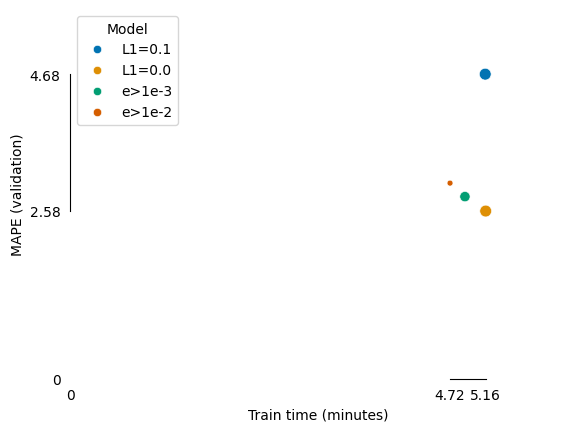

In [140]:
fig, ax = plt.subplots()

fr_plot = sns.scatterplot(fr_res, x='train_time', y='MAPE_validation', size='n_variables', hue='model', palette=palette(len(fr_res)))

ax.set_xlim(0, fr_res.train_time.max() + 1)
ax.set_ylim(0, fr_res.MAPE_validation.max() + 1)

ax.set_xlabel('Train time (minutes)')
ax.set_ylabel('MAPE (validation)')

neaten_ticks(ax, 'x', [fr_res.train_time.min(), fr_res.train_time.max()], [0], dp=2)
neaten_ticks(ax, 'y', [fr_res.MAPE_validation.min(), fr_res.MAPE_validation.max()], [0], dp=2)
ax.tick_params(axis='both', color='white')

plt.legend(title='Model', handles=fr_plot.get_children()[2:6])

show(fig, [ax], style_legend=False)


# Training times


In [348]:
ttimes = pd.read_csv('models/train_times.csv', parse_dates=['start_time'])
ttimes.train_time = ttimes.train_time.astype('timedelta64[ns]')
ttimes['total_minutes'] = ttimes.train_time.dt.total_seconds() / 60
ttimes['total_hours'] = ttimes.total_minutes / 60
ttimes['label'] = ttimes.model.apply(to_model_label)

ttimes


,model,start_time,train_time,epochs,steps,total_minutes,total_hours,label
0,Final_MLP_shallow_multiv,2024-04-11 23:28:57.676672,0 days 02:01:59.548757,10000,2456,121.992479,2.033208,Multivariate Shallow MLP
1,Final_MLP_deep_multiv,2024-04-12 01:30:58.811206,0 days 01:48:00.476131,4000,2456,108.007936,1.800132,Multivariate Deep MLP
2,Final_LSTM_shallow_multiv,2024-04-12 03:19:00.561206,0 days 02:08:37.538500,73,2456,128.625642,2.143761,Multivariate Shallow BD-LSTM
3,Final_LSTM_deep_multiv,2024-04-12 05:27:52.354039,0 days 01:59:34.425274,21,2456,119.573755,1.992896,Multivariate Deep BD-LSTM
4,Final_MLP_shallow_univ,2024-04-12 07:28:18.614487,0 days 01:57:50.300272,10500,2456,117.838338,1.963972,Univariate Shallow MLP
5,Final_MLP_deep_univ,2024-04-12 09:58:48.883013,0 days 01:44:32.686466,3950,2456,104.544774,1.742413,Univariate Deep MLP
6,Final_LSTM_shallow_univ,2024-04-12 11:43:22.791439,0 days 02:11:04.185515,105,2456,131.069759,2.184496,Univariate Shallow BD-LSTM
7,Final_LSTM_deep_univ,2024-04-12 13:54:37.849943,0 days 02:12:59.734693,30,2456,132.995578,2.216593,Univariate Deep BD-LSTM
8,Extended_Final_LSTM_deep_multiv,2024-04-12 23:13:51.562519,0 days 03:57:31.763749,84,2456,237.529396,3.958823,Multivariate Deep BD-LSTM
9,Extended_Final_LSTM_deep_univ,2024-04-13 09:07:24.221449,0 days 04:54:25.200049,120,2456,294.420001,4.907000,Univariate Deep BD-LSTM


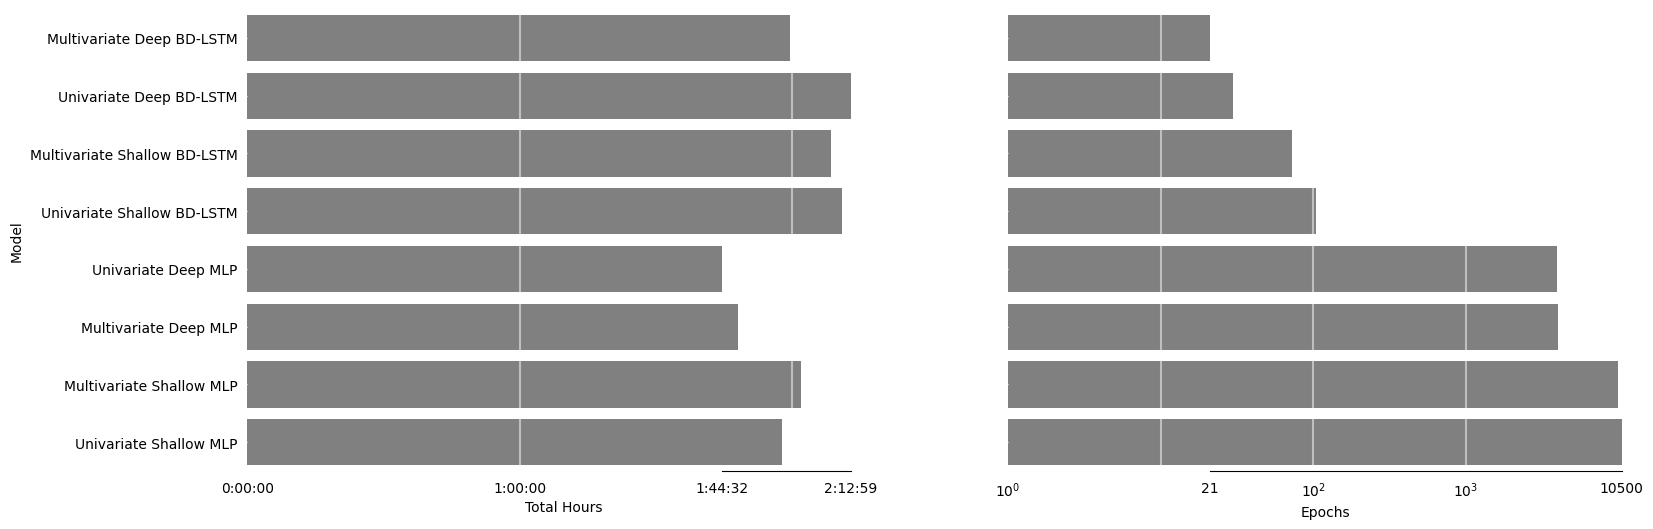

In [386]:
first_ttimes = ttimes[ttimes.model.str.match('^Final')].sort_values('epochs')

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, col in enumerate(['total_hours', 'epochs']):
    ax = axes[i]

    sns.barplot(data=first_ttimes, x=col, y='label', ax=ax, color='grey')

    ax.tick_params(axis='both', color='white')
    ax.spines['left'].set_visible(False)

    ax.set_xlabel(col.replace('_', ' ').title())
    
    if i == 0:
        ax.set_ylabel('Model')
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')

    if col == 'epochs':
        ax.set_xscale('log')
        ax.set_xlim(1)
        x_ticks = [1, 100, 1000]
        x_grid = [10, 100, 1000]
    else:
        x_ticks = [0, 1]
        x_grid = [1, 2]

    neaten_ticks(ax, 'x', [first_ttimes[col].min(), first_ttimes[col].max()], x_ticks, dp=2)

    if col == 'total_hours':
        ax.set_xticklabels([str(timedelta(hours=e._x)).split('.')[0] for e in ax.get_xticklabels()])

    for line in x_grid:
        ax.axvline(line, 0, max(ax.get_xticks()), color='white', alpha=0.5)

show(fig, axes, file='two-hour training epochs.png')



# Training histories

In [350]:
train_hists = glob('models/*history.csv')

models = set([match('.*Final_(.*?) ', e).group(1) for e in train_hists])
model_hists, label_hists = dict(), dict()

for m in models:
    # model_hists[m] = 
    hists = sorted([hist for hist in train_hists if m in hist], key=lambda e: e.count('Extended'))
    full_hist = pd.DataFrame()
    epoch = 0
    for hist in hists:
        partial_hist = pd.read_csv(hist).reset_index().rename(columns={'index': 'epoch'})
        partial_hist.epoch += 1 + epoch
        epoch = partial_hist.epoch.max()
        full_hist = pd.concat([full_hist, partial_hist]).reset_index(drop=True)
    label_hists[to_model_label(m)] = full_hist

label_hists


{'Univariate Deep BD-LSTM':      epoch       loss  mean_squared_error   val_loss  val_mean_squared_error  \
 0        1  95.134033        3.466062e+07  95.754639            2.496652e+07   
 1        2  92.553932        3.326910e+07  95.505760            2.484524e+07   
 2        3  90.101318        3.291426e+07  93.045738            2.366286e+07   
 3        4  87.954796        3.194276e+07  92.799782            2.354630e+07   
 4        5  85.517342        3.160280e+07  90.348198            2.240061e+07   
 ..     ...        ...                 ...        ...                     ...   
 145    146   6.279794        5.003939e+05   5.869787            2.017524e+05   
 146    147   6.240767        4.864562e+05   6.155232            2.056116e+05   
 147    148   6.158990        4.753613e+05   5.837444            2.019738e+05   
 148    149   6.121006        4.621438e+05   6.163714            2.066673e+05   
 149    150   6.045543        4.521712e+05   5.862945            2.039488e+05   
 

In [351]:
ttimes.groupby('label').epochs.sum().sort_index() == pd.Series({k: v.epoch.max() for k, v in sorted(label_hists.items(), key=lambda e: e[1].epoch.max())}).sort_index()


label
Multivariate Deep BD-LSTM       True
Multivariate Deep MLP           True
Multivariate Shallow BD-LSTM    True
Multivariate Shallow MLP        True
Univariate Deep BD-LSTM         True
Univariate Deep MLP             True
Univariate Shallow BD-LSTM      True
Univariate Shallow MLP          True
dtype: bool

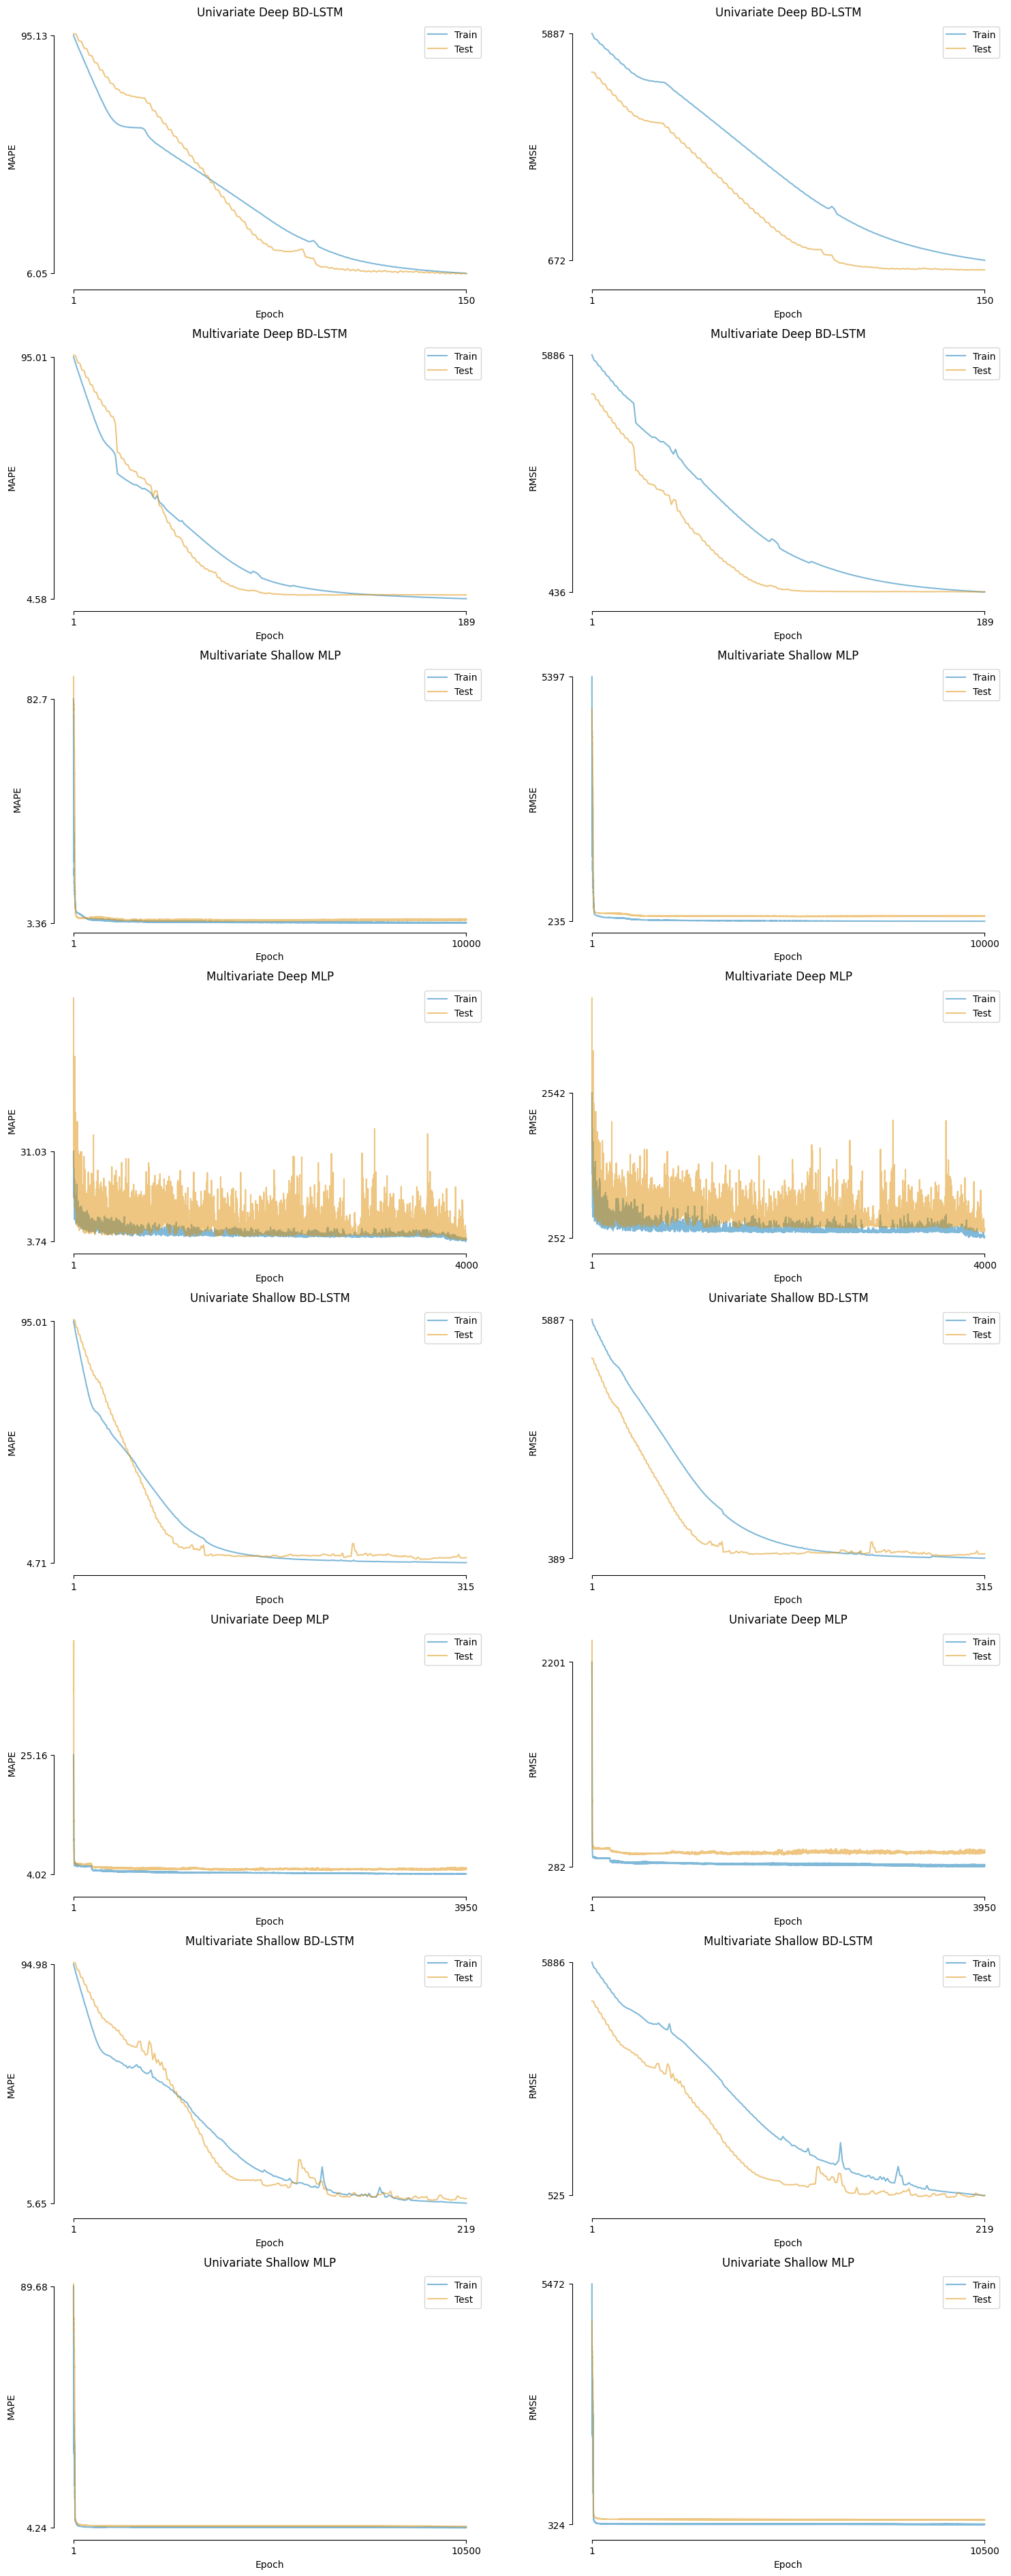

In [369]:
n_rows, n_cols = len(label_hists), 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9*n_cols, 6*n_rows))
colours = palette(2)

for i, (m, m_hist) in enumerate(label_hists.items()):
    ax_row = axes[i]
    mse_cols = [e for e in m_hist.columns if 'mean_squared_error' in e]
    m_hist[[e.replace('mean_squared_error', 'RMSE') for e in mse_cols]] = m_hist[mse_cols].apply(lambda d: d.apply(lambda e: e**.5), axis=1)
    
    metrics = ['loss', 'RMSE']
    
    for j, ax in enumerate(ax_row):
    
        metric = metrics[j]
        label = metric.replace('loss', 'MAPE')

        sns.lineplot(m_hist, x='epoch', y=metric, ax=ax, label='Train', alpha=0.5, c=colours[0])
        sns.lineplot(m_hist, x='epoch', y=f"val_{metric}", ax=ax, label='Test', alpha=0.5, c=colours[1])
    
        ax.set_ylim(0)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(label)
        ax.set_title(m)
        # ax.set_yscale('symlog')
    
        neaten_ticks(ax, 'x', [m_hist.epoch.min(), m_hist.epoch.max()], [])
        neaten_ticks(ax, 'y', [m_hist[metric].min(), m_hist[metric].max()], [], dp= 2 if label == 'MAPE' else 0)
        
    # break
    
    # plt.suptitle('M3')
    # plt.savefig(f'{fig_dir}LSTM_shallow_multiv continued fitting.png', dpi=300, facecolor='white', edgecolor='white', bbox_inches='tight')
    
show(fig, axes.flatten(), file='training times')
    


# Test results


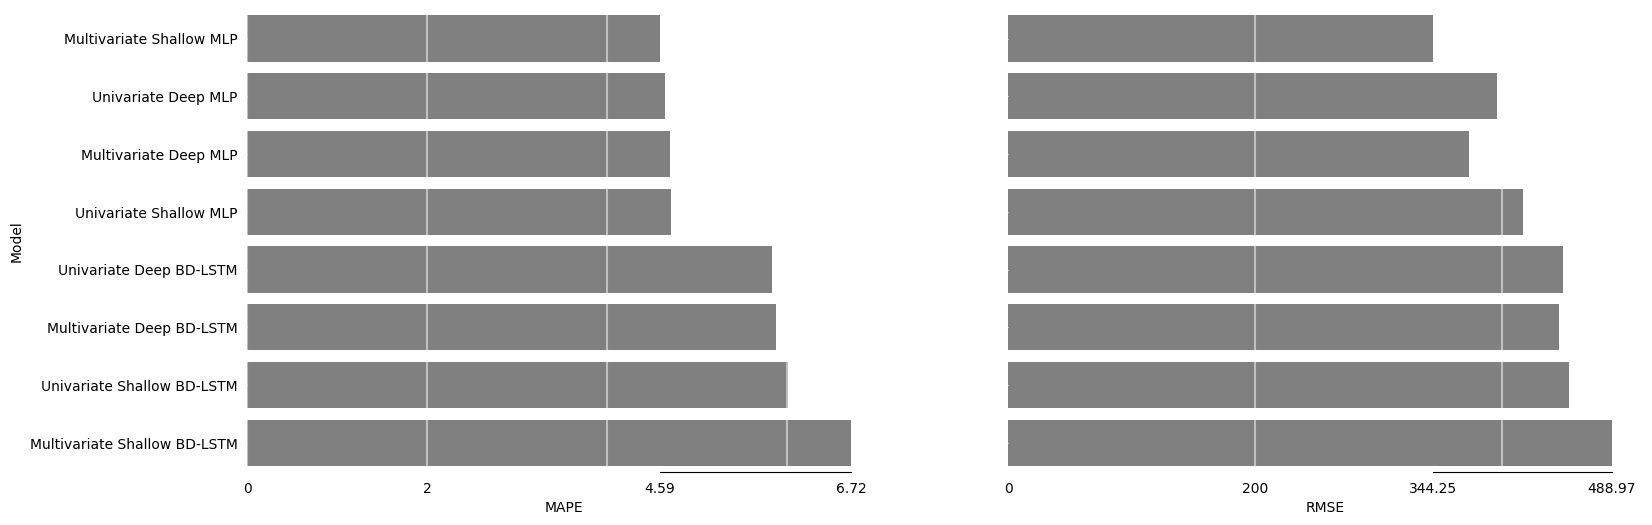

In [392]:
tests = pd.read_csv('Results/model test results.csv').sort_values('test_MAPE')
tests.model = tests.model.apply(to_model_label)

metrics = [e for e in tests.columns if 'test' in e]
n_cols = len(metrics)
fig, axes = plt.subplots(1, n_cols, figsize=(9*n_cols, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(tests, x=metric, y='model', ax=ax, color='grey')

    ax.tick_params(axis='both', color='white')
    ax.spines['left'].set_visible(False)

    ax.set_xlabel(metric.split('_')[1].upper())
    
    if i == 0:
        ax.set_ylabel('Model')
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')

    if metric == 'test_MAPE':
        x_ticks = [0, 2]
        x_grid = [0, 2, 4, 6]
    else:
        x_ticks = [0, 200]
        x_grid = [200, 400]

    neaten_ticks(ax, 'x', [tests[metric].min(), tests[metric].max()], x_ticks, dp=2)

    for line in x_grid:
        ax.axvline(line, 0, max(ax.get_xticks()), color='white', alpha=0.5)

show(fig, axes, file='Model test results.png')


0        Multivariate Shallow MLP
7             Univariate Deep MLP
4           Multivariate Deep MLP
6          Univariate Shallow MLP
5         Univariate Deep BD-LSTM
2       Multivariate Deep BD-LSTM
1      Univariate Shallow BD-LSTM
3    Multivariate Shallow BD-LSTM
Name: model, dtype: object